# Normalize data to MNI template

This example covers the normalization of data. Some people prefer to normalize the data during the preprocessing, just before smoothing. I prefer to do the 1st-level analysis completely in subject space and only normalize the contrasts for the 2nd-level analysis. But both approaches are fine.

For the current example, we will take the computed 1st-level contrasts from the previous experiment (again once done with fwhm=4mm and fwhm=8mm) and normalize them into MNI-space. To show two different approaches, we will do the normalization once with ANTs and once with SPM.

## Preparation

Before we can start with the ANTs example, we first need to download the already computed deformation field. The data can be found in the `derivatives/fmriprep` folder of the dataset and can be downloaded with the following `datalad` command:

**Note:** This might take a while, as datalad needs to download ~710MB of data

### Alternatively: Prepare yourself
We're using the precomputed warp field from [fmriprep](http://fmriprep.readthedocs.io), as this step otherwise would take up to 10 hours or more for all subjects to complete. If you're nonetheless interested in computing the warp parameters with ANTs yourself, without using [fmriprep](http://fmriprep.readthedocs.io), either check out the script [ANTS_registration.py](https://github.com/miykael/nipype_tutorial/blob/master/notebooks/scripts/ANTS_registration.py) or even quicker, use [RegistrationSynQuick](http://nipype.readthedocs.io/en/latest/interfaces/generated/interfaces.ants/registration.html#registrationsynquick), Nipype's implementation of `antsRegistrationSynQuick.sh`.

## Normalization with ANTs

The normalization with ANTs requires that you first compute the transformation matrix that would bring the anatomical images of each subject into template space. Depending on your system this might take a few hours per subject. To facilitate this step, the transformation matrix is already computed for the T1 images.

The data for it can be found under:

In [2]:
!ls /home/neuro/Data/ds000114/derivatives/fmriprep/sub-*/anat/*h5

/home/neuro/Data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/Data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/Data/ds000114/derivatives/fmriprep/sub-03/anat/sub-03_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/Data/ds000114/derivatives/fmriprep/sub-04/anat/sub-04_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/Data/ds000114/derivatives/fmriprep/sub-05/anat/sub-05_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/Data/ds000114/derivatives/fmriprep/sub-06/anat/sub-06_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/Data/ds000114/derivatives/fmriprep/sub-07/anat/sub-07_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/Data/ds000114/derivatives/fmriprep/sub-08/anat/sub-08_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/Data/ds000114/derivatives/fmriprep/sub-09/anat/sub-09_t1w_space-mni152nlin2009casym_warp.h5
/home/neuro/Data/ds000114/derivatives/fmriprep/sub-10/anat/sub-1

**Now, let's start with the ANTs normalization workflow!**

## Imports (ANTs)

First, we need to import all the modules we later want to use.

In [1]:
from os.path import join as opj
from nipype import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Info

211107-13:50:43,630 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.6.1


## Experiment parameters (ANTs)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left-handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [3]:
experiment_dir = '/home/neuro/Result/Nipype_tutorial/working_dir'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers (remember we use only right handed subjects)
subject_list = ['02', '03', '04', '05', '07', '08', '09']

# task name
task_name = "fingerfootlips"

# Smoothing widths used during preprocessing
fwhm = [4, 8]

# Template to normalize to
template = '/home/neuro/Data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

**Note** if you're not using the corresponding docker image, than the **``template``** file might not be in your ``data``  directory. To get ``mni_icbm152_nlin_asym_09c``, either download it from this [website](https://files.osf.io/v1/resources/fvuh8/providers/osfstorage/580705089ad5a101f17944a9), unpack it and move it to ``/data/ds000114/derivatives/fmriprep/`` or run the following command in a cell:

```bash
%%bash
curl -L https://files.osf.io/v1/resources/fvuh8/providers/osfstorage/580705089ad5a101f17944a9 \
     -o /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz
     
tar xf /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz \
    -C /data/ds000114/derivatives/fmriprep/.
    
rm /data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c.tar.gz
```

## Specify Nodes (ANTs)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [5]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

## Specify input & output stream (ANTs)

Specify where the input data can be found & where and how to save the output data.

In [6]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        'sub-{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'transform': opj('/home/neuro/Data/ds000114/derivatives/fmriprep/', 'sub-{subject_id}', 'anat',
                              'sub-{subject_id}_t1w_space-mni152nlin2009casym_warp.h5')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(9)] # number of contrast used in 1stlevel an.
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (ANTs)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [8]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'norm_ants.@con')]),
                  ])

## Visualize the workflow (ANTs)

It always helps to visualize your workflow.

211107-14:37:46,101 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Nipype_tutorial/working_dir/workingdir/antsflow/graph.png (graph2use=flat, simple_form=True).


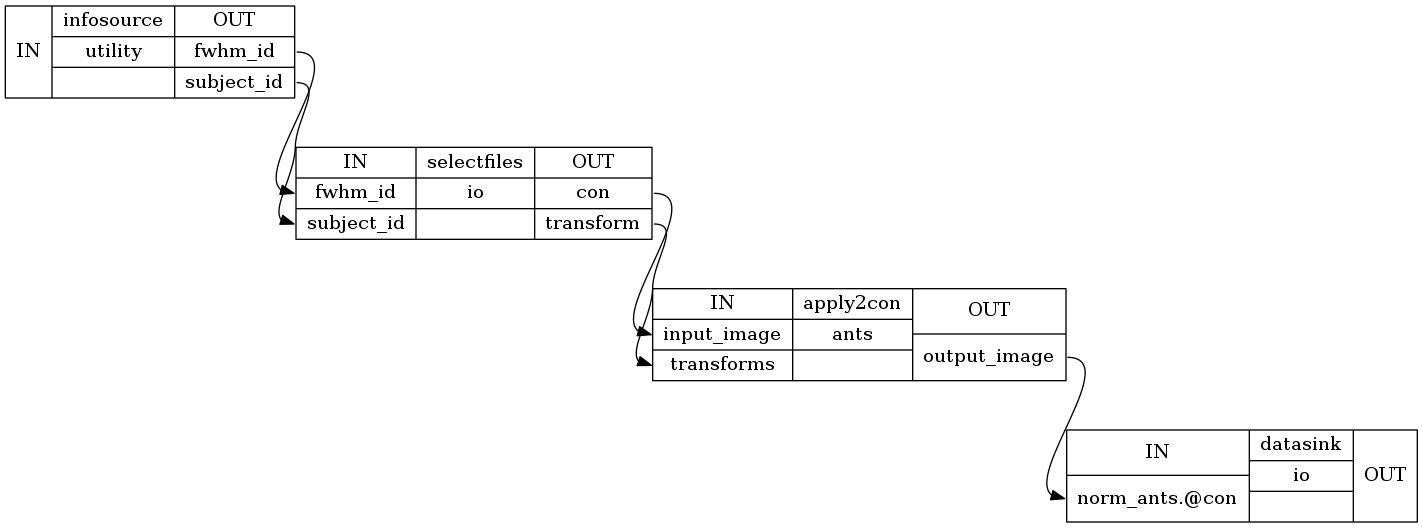

In [13]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='flat', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(antsflow.base_dir, 'antsflow', 'graph_detailed.png'))

##  Run the Workflow (ANTs)

Now that everything is ready, we can run the ANTs normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [14]:
antsflow.run('MultiProc', plugin_args={'n_procs': 4})

211107-14:37:51,820 nipype.workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging', 'monitoring']
211107-14:37:51,951 nipype.workflow INFO:
	 Running in parallel.
211107-14:37:51,953 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-14:37:52,5 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/antsflow/_fwhm_id_8_subject_id_09/selectfiles".
211107-14:37:52,7 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/antsflow/_fwhm_id_4_subject_id_09/selectfiles".
211107-14:37:52,9 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/antsflow/_fwhm_id_8_subject_id_08/selectfiles".
211107-14:37:52,11 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/home

# Normalization with SPM12

The normalization with SPM12 is rather straightforward. The only thing we need to do is run the Normalize12 module. **So let's start!**

## Imports (SPM12)

First, we need to import all the modules we later want to use.

In [15]:
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype import Workflow, Node

## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left-handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [16]:
experiment_dir = '/home/neuro/Result/Nipype_tutorial/working_dir'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['02', '03', '04', '05', '07', '08', '09']

# task name
task_name = "fingerfootlips"

# Smoothing withds used during preprocessing
fwhm = [4, 8]

template = '/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [17]:
# Gunzip - unzip the anatomical image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

stty: 'standard input': Inappropriate ioctl for device


## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [18]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'con': opj(output_dir, '1stLevel',
                        'sub-{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'anat': opj('/home/neuro/Data/ds000114/derivatives', 'fmriprep', 'sub-{subject_id}',
                         'anat', 'sub-{subject_id}_t1w_preproc.nii.gz')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [19]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('fwhm_id', 'fwhm_id')]),
                 (selectfiles, normalize, [('con', 'apply_to_files')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, normalize, [('out_file', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

211107-15:00:23,151 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/graph.png (graph2use=colored, simple_form=True).


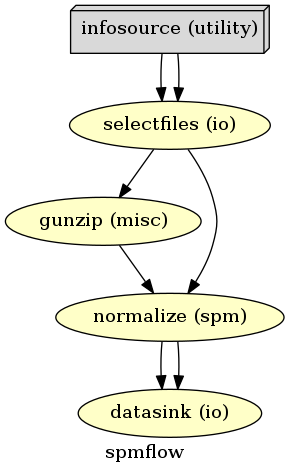

In [20]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph.png'))

##  Run the Workflow (SPM12)

Now that everything is ready, we can run the SPM normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [21]:
spmflow.run('MultiProc', plugin_args={'n_procs': 4})

211107-15:01:05,680 nipype.workflow INFO:
	 Workflow spmflow settings: ['check', 'execution', 'logging', 'monitoring']
211107-15:01:05,801 nipype.workflow INFO:
	 Running in parallel.
211107-15:01:05,803 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 14 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-15:01:05,857 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_09/selectfiles".
211107-15:01:05,860 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_4_subject_id_09/selectfiles".
211107-15:01:05,862 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_08/selectfiles".
211107-15:01:05,863 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/

stty: 'standard input': Inappropriate ioctl for device


211107-15:04:38,861 nipype.workflow INFO:
	 [Node] Finished "spmflow.normalize".


stty: 'standard input': Inappropriate ioctl for device


211107-15:04:40,11 nipype.workflow INFO:
	 [Job 10] Completed (spmflow.normalize).
211107-15:04:40,12 nipype.workflow INFO:
	 [Job 14] Completed (spmflow.normalize).
211107-15:04:40,13 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 12 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
211107-15:04:40,55 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_08/datasink".
211107-15:04:40,57 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_4_subject_id_08/datasink".
211107-15:04:40,94 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-15:04:40,96 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working

stty: 'standard input': Inappropriate ioctl for device


211107-15:04:42,407 nipype.workflow INFO:
	 [Node] Finished "spmflow.normalize".


stty: 'standard input': Inappropriate ioctl for device


211107-15:04:44,13 nipype.workflow INFO:
	 [Job 2] Completed (spmflow.normalize).
211107-15:04:44,14 nipype.workflow INFO:
	 [Job 6] Completed (spmflow.normalize).
211107-15:04:44,15 nipype.workflow INFO:
	 [Job 16] Completed (spmflow.selectfiles).
211107-15:04:44,16 nipype.workflow INFO:
	 [Job 20] Completed (spmflow.selectfiles).
211107-15:04:44,17 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 12 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-15:04:44,56 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_09/datasink".
211107-15:04:44,57 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_4_subject_id_09/datasink".
211107-15:04:44,58 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.gunzip" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwh

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-15:07:52,196 nipype.workflow INFO:
	 [Job 18] Completed (spmflow.normalize).
211107-15:07:52,197 nipype.workflow INFO:
	 [Job 22] Completed (spmflow.normalize).
211107-15:07:52,198 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 8 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
211107-15:07:52,242 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_07/datasink".
211107-15:07:52,244 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_4_subject_id_07/datasink".
211107-15:07:52,275 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-15:07:52,277 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/w

stty: 'standard input': Inappropriate ioctl for device


211107-15:08:36,235 nipype.workflow INFO:
	 [Job 26] Completed (spmflow.normalize).
211107-15:08:36,237 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 5 jobs ready. Free memory (GB): 6.83/7.43, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211107-15:08:36,278 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_05/datasink".
211107-15:08:36,311 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-15:08:36,313 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/_fwhm_id_8_subject_id_05/wcon_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/sub-05_fwhm8/wcon_0001.nii
211107-15:08:36,330 nipype.interface INFO:
	 sub: /home/neuro/Res

stty: 'standard input': Inappropriate ioctl for device


211107-15:08:38,237 nipype.workflow INFO:
	 [Job 30] Completed (spmflow.normalize).
211107-15:08:38,238 nipype.workflow INFO:
	 [Job 27] Completed (spmflow.datasink).
211107-15:08:38,240 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 5 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
211107-15:08:38,283 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_4_subject_id_05/datasink".
211107-15:08:38,284 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_03/selectfiles".
211107-15:08:38,316 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211107-15:08:38,318 nipype.workflow INFO:
	 [Node] Running "datasink" ("nip

stty: 'standard input': Inappropriate ioctl for device


211107-15:11:42,306 nipype.workflow INFO:
	 [Node] Finished "spmflow.normalize".
211107-15:11:42,414 nipype.workflow INFO:
	 [Job 42] Completed (spmflow.normalize).
211107-15:11:42,415 nipype.workflow INFO:
	 [Job 46] Completed (spmflow.normalize).
211107-15:11:42,417 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 4 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize


stty: 'standard input': Inappropriate ioctl for device


211107-15:11:42,455 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_03/datasink".
211107-15:11:42,457 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_4_subject_id_03/datasink".
211107-15:11:42,486 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-15:11:42,487 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-15:11:42,488 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/_fwhm_id_8_subject_id_03/wcon_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/sub-03_fwhm8/wcon_0001.nii
211107-15:11:42,488 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/_fwhm_id_4_subject_id_03/wcon_0001.nii -> /home/neuro/

stty: 'standard input': Inappropriate ioctl for device
stty: 'standard input': Inappropriate ioctl for device


211107-15:11:48,818 nipype.workflow INFO:
	 [Node] Finished "spmflow.normalize".
211107-15:11:49,518 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211107-15:11:49,518 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211107-15:11:50,422 nipype.workflow INFO:
	 [Job 34] Completed (spmflow.normalize).
211107-15:11:50,423 nipype.workflow INFO:
	 [Job 38] Completed (spmflow.normalize).
211107-15:11:50,425 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 2 jobs ready. Free memory (GB): 7.03/7.43, Free processors: 2/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
211107-15:11:50,465 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_04/datasink".
211107-15:11:50,467 nipype.workflow INFO:
	 [Node] Setti

stty: 'standard input': Inappropriate ioctl for device


211107-15:16:02,675 nipype.workflow INFO:
	 [Job 50] Completed (spmflow.normalize).
211107-15:16:02,677 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 7.23/7.43, Free processors: 3/4.
                     Currently running:
                       * spmflow.normalize
211107-15:16:02,720 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_8_subject_id_02/datasink".
211107-15:16:02,752 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-15:16:02,753 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/_fwhm_id_8_subject_id_02/wcon_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/sub-02_fwhm8/wcon_0001.nii
211107-15:16:02,767 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/_fwhm_id_8_subject_id_02/wcon_0002.n

stty: 'standard input': Inappropriate ioctl for device


211107-15:16:04,677 nipype.workflow INFO:
	 [Job 54] Completed (spmflow.normalize).
211107-15:16:04,679 nipype.workflow INFO:
	 [Job 51] Completed (spmflow.datasink).
211107-15:16:04,680 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 7.43/7.43, Free processors: 4/4.
211107-15:16:04,722 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Nipype_tutorial/working_dir/workingdir/spmflow/_fwhm_id_4_subject_id_02/datasink".
211107-15:16:04,755 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211107-15:16:04,756 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/_fwhm_id_4_subject_id_02/wcon_0001.nii -> /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/sub-02_fwhm4/wcon_0001.nii
211107-15:16:04,769 nipype.interface INFO:
	 sub: /home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/_fwhm_id_4_subject_id_02/wcon_0002.n

# Comparison between ANTs and SPM normalization

Now that we ran the normalization with ANTs and SPM, let us compare their output.

In [23]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = '/home/neuro/Data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

First, let's compare the normalization of the **anatomical** images:

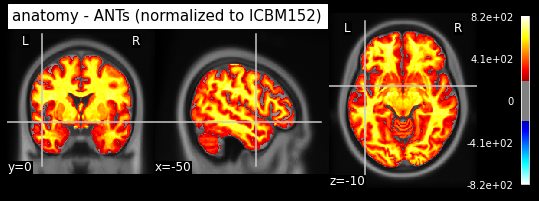

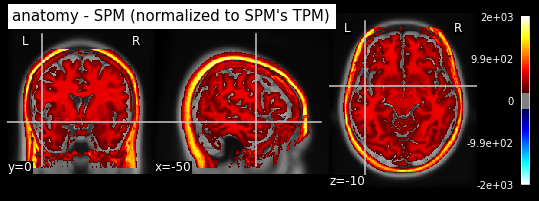

In [24]:
plot_stat_map(
    '/home/neuro/Data/ds000114/derivatives/fmriprep/sub-02/anat/sub-02_t1w_space-mni152nlin2009casym_preproc.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10));
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/sub-02_fwhm4/wsub-02_t1w_preproc.nii',
    title='anatomy - SPM (normalized to SPM\'s TPM)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10));

And what about the **contrast** images for **Finger > others**?

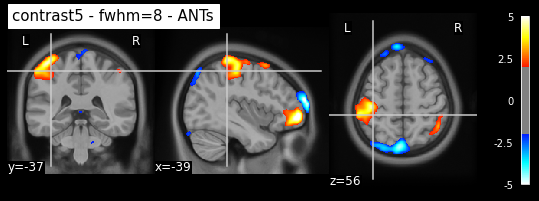

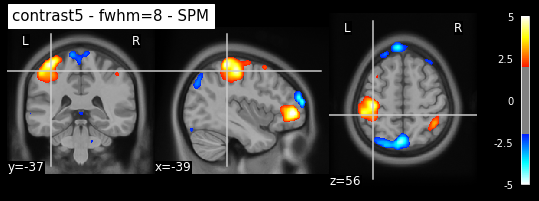

In [25]:
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_ants/sub-02_fwhm8/con_0005_trans.nii', title='contrast5 - fwhm=8 - ANTs',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56));
plot_stat_map(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/sub-02_fwhm8/wcon_0005.nii', title='contrast5 - fwhm=8 - SPM',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56));

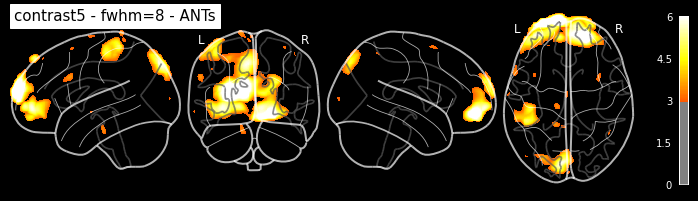

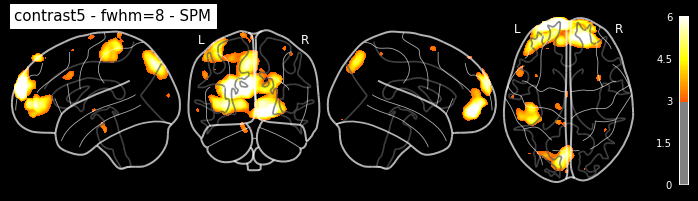

In [26]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_ants/sub-02_fwhm8/con_0005_trans.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - fwhm=8 - ANTs')
plot_glass_brain(
    '/home/neuro/Result/Nipype_tutorial/working_dir/datasink/norm_spm/sub-02_fwhm8/wcon_0005.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - fwhm=8 - SPM');